# TME4 FDMS Collaborative Filtering 

Florian Toqué & Paul Willot

In [1]:
%matplotlib inline
from random import random
import math
import numpy as np
import copy
from scipy import stats
import matplotlib.pyplot as plt
import pickle as pkl
from scipy.spatial import distance
import seaborn as sns
sns.set_style('darkgrid')

## Loading the data

In [2]:
def loadMovieLens(path='./data/movielens'):
    #Get movie titles
    movies={}
    rev_movies={}
    for idx,line in enumerate(open(path+'/u.item')):
        idx,title=line.split('|')[0:2]
        movies[idx]=title
        rev_movies[title]=idx

    # Load data
    prefs={}
    for line in open(path+'/u.data'):
        (user,movieid,rating,ts)=line.split('\t')
        prefs.setdefault(user,{})
        prefs[user][movies[movieid]]=float(rating)
        
    return prefs,rev_movies

In [107]:
data,movies = loadMovieLens("data/ml-100k")

### Splitting data between train/test  

We avoid to let unseen data form the train set in the test set.  
We also try to minimise the dataset reduction by splitting on each user.

In [7]:
def getRawArray(data):
    d = []
    for u in data.keys():
        for i in data[u].keys():
            d.append([u,i,data[u][i]])
    return np.array(d)
# splitting while avoiding to reduce the dataset too much
def split_train_test(data,percent_test):
    test={}
    train={}
    movie={}
    for u in data.keys():
        test.setdefault(u,{})
        train.setdefault(u,{})
        for movie in data[u]:
            #print(data[u][movie])
            if (random()<percent_test):
                test[u][movie]=data[u][movie]
            else:
                train[u][movie]=data[u][movie]
    return train, test
def split_train_test_by_movies(data,percent_test):
    test={}
    train={}
    movie={}
    for u in data.keys():
        for movie in data[u]:
            if (random()<percent_test):
                try:
                    test[movie][u]=data[u][movie]
                except KeyError:
                    test.setdefault(movie,{})
                    test[movie][u]=data[u][movie]
            else:
                try:
                    train[movie][u]=data[u][movie]
                except KeyError:
                    train.setdefault(movie,{})
                    train[movie][u]=data[u][movie]
    return train, test

_split used for convenience on the average by movie baseline_

In [9]:
percent_test = 0.2
train,test = split_train_test(data,percent_test)
m_train,m_test = split_train_test_by_movies(data,percent_test)

_cleaning_  
18 movies have no ratings at all

In [31]:
def deleteUnseenInTest(train,test):
    for k in test.keys():
        try:
            train[k]
        except KeyError:
            test.pop(k,None)

In [62]:
def deleteUnknowData(triplet_test, trainUsers, trainItems) :
    to_Del = []
    for i,t in enumerate(triplet_test):
        if not t[0] in trainUsers:
            to_Del.append(i)
        elif not t[1] in trainItems:
            to_Del.append(i)
    return np.delete(triplet_test, to_Del, 0)

In [32]:
deleteUnseenInTest(train,test)
deleteUnseenInTest(m_train,m_test)

Matrix used for fast evaluation

In [14]:
def getRawArray(data):
    rawArray = []
    for u in data.keys():
        for i in data[u].keys():
            rawArray.append([u,i,data[u][i]])
    return rawArray

def getDataByUsers(rawArray) :
    usr = {}
    for t in rawArray:
        if not t[0] in usr.keys():
            usr[t[0]] = {}
        usr[t[0]][t[1]] = float(t[2])
    return usr

def getDataByItems(rawArray) :
    itm = {}
    for t in rawArray:
        if not t[1] in itm.keys():
            itm[t[1]] = {}
        itm[t[1]][t[0]] = float(t[2])
    return itm

# Split l'ensemble des rawArrays  
def splitTrainTest(rawArray, testProp) :
    perm = np.random.permutation(rawArray)
    splitIndex = int(testProp * len(rawArray))
    return perm[splitIndex:], perm[:splitIndex]

# supprime des données de test les données inconnus en train
def deleteUnknowData(rawArray_test, trainUsers, trainItems) :
    to_Del = []
    for i,t in enumerate(rawArray_test):
        if not t[0] in trainUsers:
            to_Del.append(i)
        elif not t[1] in trainItems:
            to_Del.append(i)
    return np.delete(rawArray_test, to_Del, 0)
    

In [15]:
%%time

rawArray = getRawArray(data)

arrayTrain, arrayTest = splitTrainTest(rawArray , 0.2)

trainUsers = getDataByUsers(arrayTrain)
trainItems = getDataByItems(arrayTrain)

arrayTest = deleteUnknowData(arrayTest, trainUsers, trainItems)

testUsers = getDataByUsers(arrayTest)
testItems = getDataByItems(arrayTest)

CPU times: user 4.93 s, sys: 78.9 ms, total: 5.01 s
Wall time: 5.07 s


Content example

In [16]:
arrayTest[:10,:10]

array([['880', 'War, The (1994)', '2.0'],
       ['407', 'True Lies (1994)', '4.0'],
       ['767',
        'Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964)',
        '5.0'],
       ['934', 'On Golden Pond (1981)', '3.0'],
       ['597', 'Fifth Element, The (1997)', '4.0'],
       ['686', 'Pink Floyd - The Wall (1982)', '5.0'],
       ['452', 'Firm, The (1993)', '3.0'],
       ['828', 'In & Out (1997)', '2.0'],
       ['7', 'Rosencrantz and Guildenstern Are Dead (1990)', '3.0'],
       ['357', 'Twelve Monkeys (1995)', '3.0']], 
      dtype='|S81')

---

## Baseline: mean by user

In [17]:
class baselineMeanUser:
    def __init__(self):
        self.users={}
    def fit(self,train):
        for user in train.keys():
            note=0.0
            for movie in train[user].keys():
                note+=train[user][movie]
            note=note/len(train[user])
            self.users[user]=note
        
    def predict(self,users):
        return [self.users[u] for u in users]

In [19]:
baseline_mu= baselineMeanUser()
baseline_mu.fit(train)
pred = baseline_mu.predict(arrayTest[:,0])
print("Mean Error %0.6f" %(
        (np.array(pred) - np.array(arrayTest[:,2], float)) ** 2).mean())

Mean Error 1.061685


In [21]:
class baselineMeanMovie:
    def __init__(self):
        self.movies={}
    def fit(self,train):
        for movie in train.keys():
            note=0.0
            for user in train[movie].keys():
                note+=train[movie][user]
            note=note/len(train[movie])
            self.movies[movie]=note
        
    def predict(self,movies):
        res=[]
        for m in movies:
            try:
                res.append(self.movies[m])
            except:
                res.append(3)
        return res

In [22]:
baseline_mm= baselineMeanMovie()
baseline_mm.fit(m_train)
pred = baseline_mm.predict(arrayTest[:,1])
print("Mean Error %0.6f" %(
        (np.array(pred) - np.array(arrayTest[:,2], float)) ** 2).mean())

Mean Error 1.009039


---

Raw matrix are used for convenience and clarity.  
Structure like scipy sparse matrix or python dictionnaries may be used for speedup.

_Complete dataset_

In [23]:
rawMatrix = np.zeros((943,1682))
for u in data:
    for m in data[u]:
        rawMatrix[int(u)-1][int(movies[m])-1] = data[u][m]

In [24]:
print(np.shape(rawMatrix))
rawMatrix[:5,:5]

(943, 1682)


array([[ 5.,  3.,  4.,  3.,  3.],
       [ 4.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 4.,  3.,  0.,  0.,  0.]])

_Train and test dataset_

In [25]:
rawMatrixTrain = np.zeros((len(data.keys()),1682))
for u in train:
    for m in train[u]:
        rawMatrixTrain[int(u)-1][int(movies[m])-1] = train[u][m]
        
rawMatrixTest = np.zeros((len(data.keys()),1682))
for u in test:
    for m in test[u]:
        rawMatrixTest[int(u)-1][int(movies[m])-1] = test[u][m]

---
## [Non-negative Matrix Factorization](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization)

Fast implementation using numpy's matrix processing.

In [27]:
def nmf(X, latent_features, max_iter=100, eps = 1e-5,printevery=100):

    print "NMF with %d latent features, %d iterations."%(latent_features, max_iter)

    # mask used to ignore null element (coded by zero)
    mask = np.sign(X)

    # randomly initialized matrix
    rows, columns = X.shape
    A = np.random.rand(rows, latent_features)
    
    Y = np.random.rand(latent_features, columns)
    # Not used as I couldn't get it to bring significant improvments
    # Y = linalg.lstsq(A, X)[0]  # initializing that way as recommanded in a blog post
    # Y = np.maximum(Y, eps)     # avoiding too low values

    masked_X = mask * X
    masktest = np.sign(rawMatrixTest)    # used for prints
    masktrain = np.sign(rawMatrixTrain)  # used for prints

    for i in range(1, max_iter + 1):

        top = np.dot(masked_X, Y.T)
        bottom = (np.dot((mask * np.dot(A, Y)), Y.T)) + eps
        A *= top / bottom
        
        top = np.dot(A.T, masked_X)
        bottom = np.dot(A.T, mask * np.dot(A, Y)) + eps
        Y *= top / bottom


        # evaluation
        if i % printevery == 0 or i == 1 or i == max_iter:
            X_est = np.dot(A, Y)
            q = masktest*X_est - rawMatrixTest
            q_train = masktrain*X_est - rawMatrixTrain
            print "Iteration %d, Err %.05f, Err train %.05f"%( i, (q*q).sum()/ masktest.sum(), (q_train*q_train).sum()/ masktest.sum() )
            
    return A, Y

In [28]:
%%time
A,Y = nmf(rawMatrixTrain,100,eps = 1e-5,max_iter=5,printevery=1)
resMatrix = A.dot(Y)

NMF with 100 latent features, 5 iterations.
Iteration 1, Err 0.96729, Err train 3.49114
Iteration 2, Err 0.93024, Err train 3.29501
Iteration 3, Err 0.92810, Err train 3.22738
Iteration 4, Err 0.92793, Err train 3.16722
Iteration 5, Err 0.92808, Err train 3.10914
CPU times: user 1.04 s, sys: 163 ms, total: 1.2 s
Wall time: 648 ms


We see that it quickly get **better than the baseline**.  
However, we see below that it **overfit** after that:

In [29]:
%%time
A,Y = nmf(rawMatrixTrain,50,eps = 1e-5,max_iter=500,printevery=100)
resMatrix = A.dot(Y)

NMF with 50 latent features, 500 iterations.
Iteration 1, Err 0.98250, Err train 3.54950
Iteration 100, Err 1.23550, Err train 0.99918
Iteration 200, Err 1.41642, Err train 0.70384
Iteration 300, Err 1.52036, Err train 0.59914
Iteration 400, Err 1.59590, Err train 0.54513
Iteration 500, Err 1.65356, Err train 0.51195
CPU times: user 41.4 s, sys: 4.75 s, total: 46.2 s
Wall time: 22.2 s


This is due to the high sparsity of the matrix.  
We can of course reduce the features matrix size to avoid overfitting, but that will limit further improvments:

In [30]:
%%time
A,Y = nmf(rawMatrixTrain,1,eps = 1e-5,max_iter=100,printevery=20)
resMatrix = A.dot(Y)

NMF with 1 latent features, 100 iterations.
Iteration 1, Err 0.99993, Err train 3.68866
Iteration 20, Err 0.91037, Err train 3.36667
Iteration 40, Err 0.91037, Err train 3.36667
Iteration 60, Err 0.91037, Err train 3.36667
Iteration 80, Err 0.91037, Err train 3.36667
Iteration 100, Err 0.91037, Err train 3.36667
CPU times: user 3.46 s, sys: 1.05 s, total: 4.51 s
Wall time: 3.36 s


Despite good results in few seconds on this dataset, this can only get us so far.  
_We then have to add regularization to the cost function._

#### Evaluation

In [31]:
## This class is used to make predictions
class evalMF:
    def __init__(self,resMatrix,dicU,dicI):
        self.resMatrix=resMatrix
        self.dicU = dicU
        self.dicI = dicI
    def fit(self):
        pass
        
    def predict(self,user,movie):
        return self.resMatrix[int(user)-1][int(self.dicI[movie])-1]

In [32]:
mf = evalMF(resMatrix,data,movies)

In [33]:
# np.array([ (float(ra[2]) - mf.predict(ra[0],ra[1]))**2 for ra in evalArrayTest]).mean()
# faster evaluation
masqueTest=np.sign(rawMatrixTest)
q = masqueTest*resMatrix - rawMatrixTest
(q*q).sum()/ masqueTest.sum()

0.91037042739254415

Let's look at some predictions

In [35]:
print data["1"]["Akira (1988)"]
print mf.predict("1","Akira (1988)")
print data["1"]["I.Q. (1994)"]
print mf.predict("1","I.Q. (1994)")

4.0
3.42098301472
3.0
3.37312205136


We usualy see an important difference between users, so we need to take the bias into account.

In [38]:
user="1"
summ=0
for i in data[user]:
    summ+=(float(data[user][i]) - mf.predict(user,i))**2
summ/len(data[user])

0.95173954590187604

In [39]:
user="3"
summ=0
for i in data[user]:
    summ+=(float(data[user][i]) - mf.predict(user,i))**2
summ/len(data[user])

1.3391054193021186

---  

We have not been very successful with incorporating the bias and L1 into that implementation...  
**We build a simpler model below, and then add the regularization and bias.**

In [125]:
class mf():
    def __init__(self, k, eps=1e-3, nIter=2000, lambd=0.5):
        self.k = k
        self.lambd = lambd
        self.eps = eps
        self.nIter = nIter

    def fit(self, trainUsers, trainItems, rawArray):
        print "MF with %d latent features, %d iterations."%(self.k, self.nIter)

        printevery = np.round(self.nIter/10,decimals=-4)

        self.p = {}
        self.q = {}
        self.bu = {}
        self.bi = {}
        self.mu = np.random.random() * 2 - 1

        for j in range(len(rawArray)):
            u = rawArray[j][0]
            i = rawArray[j][1]
            if not u in self.p:
                self.p[u] = np.random.rand(1,self.k)
                self.bu[u] = np.random.rand() * 2 - 1
            if not i in self.q:
                self.q[i] = np.random.rand(self.k,1)
                self.bi[i] = np.random.rand() * 2 - 1
        loss = []
        for it in range(self.nIter):
            ind = np.random.randint(len(rawArray))
            u = rawArray[ind][0]
            i = rawArray[ind][1]

            # thx to A & A !
            tmp = trainUsers[u][i] - (self.mu + self.bi[i] + self.bu[u] +self.p[u].dot(self.q[i])[0][0])
            self.p[u] = (1 - self.lambd * self.eps) * self.p[u] + self.eps * 2 * tmp * self.q[i].transpose()
            self.bu[u] = (1 - self.lambd * self.eps) * self.bu[u] + self.eps * 2 * tmp
            self.q[i] = (1 - self.lambd * self.eps) * self.q[i] + self.eps * 2 * tmp * self.p[u].transpose()
            self.bi[i] = (1 - self.lambd * self.eps) * self.bi[i] + self.eps * 2 * tmp
            self.mu = (1 - self.lambd * self.eps) * self.mu + self.eps * 2 * tmp

            loss.append(tmp*tmp)

            if it % printevery == 0 or it == self.nIter-1:
                print "Iteration %s, Err %.05f, True %.05f"%( str(it).ljust(8), np.mean(loss) , model.score(arrayTest))

        return self.p, self.q


    def predict(self, rawArray_test):
        pred = np.zeros(len(rawArray_test))
        for ind,t in enumerate(rawArray_test):
            pred[ind] = self.mu + self.bu[t[0]] + self.bi[t[1]] + self.p[t[0]].dot(self.q[t[1]])[0][0]
        return pred

    def score(self, rawArray_test) :
        return ((self.predict(rawArray_test) - np.array(rawArray_test[:,2], float)) ** 2).mean()

In [97]:
%%time
k = 10
eps = 8e-3
nIter = int(2e6)
lambd = 0.2
model = mf(k, eps=eps, nIter=nIter,lambd=lambd)
p,q = model.fit(trainUsers, trainItems, arrayTrain)
print "\nError on test: %.05f" %(model.score(arrayTest))

MF with 10 latent features, 2000000 iterations.
Iteration 0       , Err 10.81438, True 2.64189
Iteration 200000  , Err 0.98134, True 0.95791
Iteration 400000  , Err 0.91824, True 0.94711
Iteration 600000  , Err 0.88776, True 0.93861
Iteration 800000  , Err 0.86562, True 0.91435
Iteration 1000000 , Err 0.84629, True 0.88711
Iteration 1200000 , Err 0.82769, True 0.87799
Iteration 1400000 , Err 0.81094, True 0.88911
Iteration 1600000 , Err 0.79622, True 0.86135
Iteration 1800000 , Err 0.78259, True 0.85800
Iteration 1999999 , Err 0.77016, True 0.87102

Error on test: 0.87102
CPU times: user 1min 10s, sys: 1.11 s, total: 1min 12s
Wall time: 1min 13s


---

thanks to [Professeur Chen](http://www.pokepedia.fr/Professeur_Chen)

In [32]:
class tSNE():
    def __init__(self,perp, nIter, lr, moment, dim=2):
        self.perp = perp # entre 5 et 50
        self.nIter = nIter
        self.lr = lr
        self.moment = moment
        self.dim = dim 
    def fit(self,data):
        nEx = np.shape(data)[0]
        # Matrice des distances de ||xi - xj||² #
        normx = np.sum(data**2,1)
        normx = np.reshape(normx, (1, nEx))
        distancex = normx + normx.T - 2 * data.dot(data.T)
        # Calcul des sigma ---------------------------------------------------------------#
        lperp = np.log2(self.perp)
        # initialisation bornes pour la recherche dichotomique #
        sup = np.ones((nEx,1)) * np.max(distancex)
        inf = np.zeros((nEx,1))
        self.sigma = (sup + inf) / 2.
        # recherche dichotomique #
        stop = False
        while not stop:
            # Calculer la matrice des p(i|j)
            self.pcond = np.exp(-distancex / (2. * (self.sigma**2)))
            self.pcond = self.pcond / np.sum(self.pcond - np.eye(nEx),1).reshape(nEx,1)
            # Calculer l'entropie de p(i|j)
            entropy = - np.sum(self.pcond * np.log2(self.pcond), 0)
            # Mise a jour des bornes
              # Si il faut augmenter sigma
            up = entropy < lperp 
            inf[up,0] = self.sigma[up,0]
              # Si il faut baisser sigma
            down = entropy > lperp 
            sup[down,0] = self.sigma[down,0]
            # Mise a jour de sigma et condition d'arrêt
            old = self.sigma
            self.sigma = ((sup + inf) / 2.)
            if np.max(np.abs(old - self.sigma)) < 1e-5:
                stop = True
                #print np.exp(entropy)
                #print self.sigma.T  
        #--------------------------------------------------------------------------#
        #initialiser y
        self.embeddings = np.zeros((self.nIter+2, nEx, self.dim))
        self.embeddings[1] = np.random.randn(nEx, self.dim) * 1e-4
        #--------------------------------------------------------------------------#
        # p(ij)
        self.pij = (self.pcond + self.pcond.T) / (2.*nEx)
        np.fill_diagonal(self.pij, 0)
        # Descente de Gradient
        for t in xrange(1,self.nIter+1):
            # Matrice des distances 
            normy = np.sum((self.embeddings[t]**2),1)
            normy = np.reshape(normy, (1, nEx))
            distancey = normy + normy.T - 2 * self.embeddings[t].dot(self.embeddings[t].T)
            # q(ij)
            # self.qij = (distancey.sum() + nEx*(nEx-1)) / (1 + distancey)
            # np.fill_diagonal(self.qij, 0)
            self.qij = 1 / (1 + distancey)
            np.fill_diagonal(self.qij, 0)
            self.qij = self.qij / self.qij.sum()
            # Descente de gradient
            yt = self.embeddings[t]
            tmpgrad = 4 * ((self.pij - self.qij) / (1 + distancey)).reshape(nEx, nEx,1)
            for i in range(nEx):
                dy = (tmpgrad[i] * (yt[i]-yt)).sum(0)
                self.embeddings[t+1][i] = yt[i] - self.lr * dy + self.moment * (yt[i] - self.embeddings[t-1,i])

In [211]:
from sklearn import datasets
from scipy import stats
digits = datasets.load_digits()

X_ini = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
cols = np.hstack([digits.target[digits.target==i]
               for i in range(10)])

In [41]:
%%time

model = tSNE(10,500,1000,0)
model.fit(X_ini)

CPU times: user 7min 27s, sys: 1min 29s, total: 8min 56s
Wall time: 21min 44s


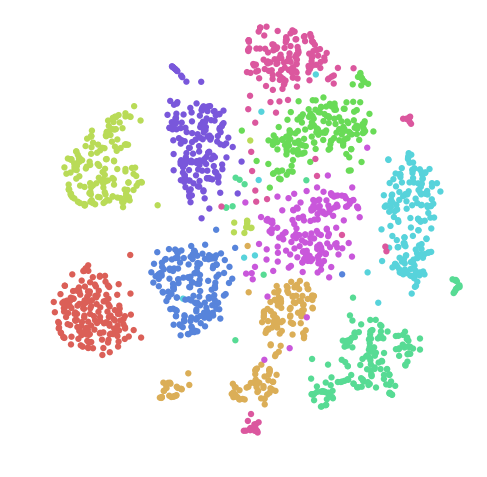

In [42]:
palette = np.array(sns.color_palette("hls", 10))
t = np.shape(model.embeddings)[0] -1

# We create a scatter plot.
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(model.embeddings[t,:,0], model.embeddings[t,:,1], lw=0, s=40,
                c=palette[cols.astype(np.int)])
plt.xlim(-25, 25)
plt.ylim(-25, 25)
ax.axis('off')
ax.axis('tight')

#plt.plot(mod.embedding_[12][0],mod.embedding_[12][1], 'bv')
        
plt.show()

For reference, let's compare it with sklearn's TSNE

In [99]:
from sklearn.manifold import TSNE

In [100]:
mod = TSNE(random_state=1337)

In [101]:
%%time
X = mod.fit_transform(X_ini)

CPU times: user 27.1 s, sys: 6.09 s, total: 33.1 s
Wall time: 34 s


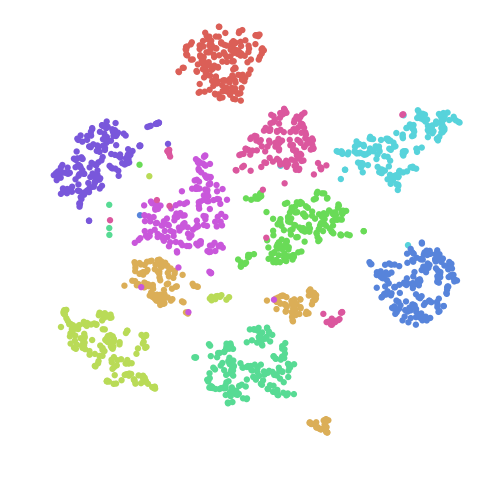

In [102]:
palette = np.array(sns.color_palette("hls", 10))

# We create a scatter plot.
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40,
                c=palette[cols.astype(np.int)])
plt.xlim(-25, 25)
plt.ylim(-25, 25)
ax.axis('off')
ax.axis('tight')

#plt.plot(mod.embedding_[12][0],mod.embedding_[12][1], 'bv')
        
plt.show()

It produce similar results, albeit faster, as expected.

In [139]:
rawMatrix = np.zeros((943,1682))
for u in data:
    for m in data[u]:
        rawMatrix[int(u)-1][int(movies[m])-1] = data[u][m]

Predict unknown data and fill the others with the right number

In [231]:
%%time
rawMatrix = np.zeros((943,1682))
for u in data:
    for m in movies.keys():
        try:
            rawMatrix[int(u)-1][int(movies[m])-1] = model.predict([[u,m]])
        except KeyError:
            rawMatrix[int(u)-1][int(movies[m])-1] = 3
for u in data:
    for m in data[u]:
        rawMatrix[int(u)-1][int(movies[m])-1] = data[u][m]

CPU times: user 13.4 s, sys: 168 ms, total: 13.5 s
Wall time: 13.9 s


In [277]:
rawMatrix[:5,:5]

array([[ 5.        ,  3.        ,  4.        ,  3.        ,  3.        ],
       [ 4.        ,  3.26235437,  2.90199025,  3.68651406,  3.31877422],
       [ 2.99220194,  2.71445886,  2.39273736,  3.0872592 ,  2.38694781],
       [ 4.2131746 ,  3.67717866,  3.24440855,  4.1865743 ,  3.78151188],
       [ 4.        ,  3.        ,  2.30836443,  3.28101521,  2.29760537]])

0.0164939277392222 percent of unseen data

In [132]:
model.predict([["1","101 Dalmatians (1996)"]])

array([ 2.20209948])

In [ ]:
rawMatrix = np.zeros((943,1682))
for u in data:
    for m in data[u]:
        rawMatrix[int(u)-1][int(movies[m])-1] = data[u][m]

In [144]:
mod = TSNE(random_state=1337)

In [236]:
%%time
X = mod.fit_transform(rawMatrix)

CPU times: user 6.74 s, sys: 1.28 s, total: 8.02 s
Wall time: 8.18 s


## Produced visualisation

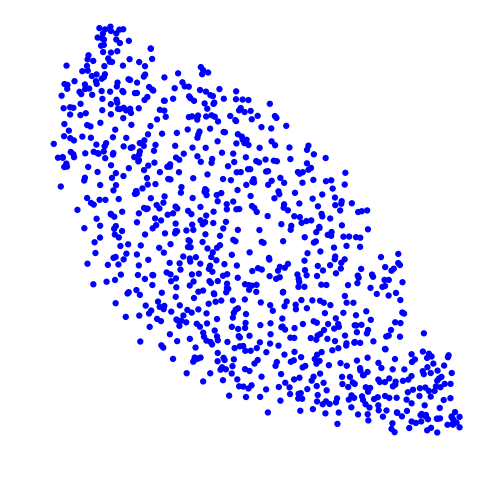

In [237]:
palette = np.array(sns.color_palette("hls", 4))

f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40)
plt.xlim(-25, 25)
plt.ylim(-25, 25)
ax.axis('off')
ax.axis('tight')
        
plt.show()

#### But its not very informative...  
#### Let's add some colors by ratings

In [257]:
me = rawMatrix.mean(1)
X_ini = np.vstack([rawMatrix[np.where(np.logical_and(me>i, me<=j))]
               for i,j in [(0,2),(2,3),(3,4),(4,5)]])
cols = np.hstack(  [ np.round( me[ np.where(np.logical_and(me>i, me<=j)) ] )
               for i,j in [(0,2),(2,3),(3,4),(4,5)] ] )

In [259]:
%%time
X = mod.fit_transform(X_ini)

CPU times: user 6.33 s, sys: 1.21 s, total: 7.54 s
Wall time: 7.56 s


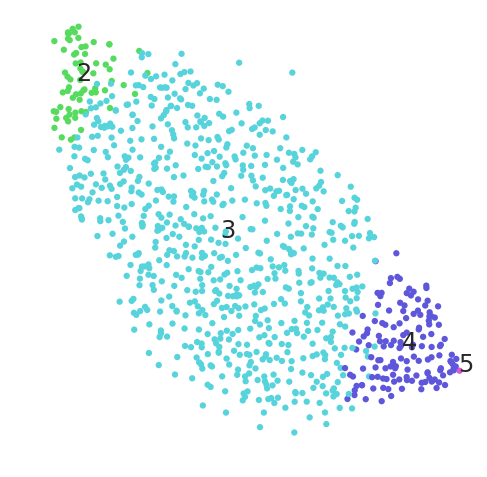

In [276]:
palette = np.array(sns.color_palette("hls", 6))

f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40,
                c=palette[cols.astype(np.int)])
plt.xlim(-25, 25)
plt.ylim(-25, 25)
ax.axis('off')
ax.axis('tight')

txts = []
for i in range(2,6):
    xtext, ytext = np.median(X[cols == i, :], axis=0)
    txt = ax.text(xtext, ytext, str(i), fontsize=24)
    txts.append(txt)

#plt.plot(mod.embedding_[12][0],mod.embedding_[12][1], 'bv')
        
plt.show()

We see that the representation make sense, as movies with best ratings are opposed to movies with low ratings

---

---

---